In [11]:
import os
import urllib.request as request
import csv

In [23]:
with open("./Phenotypic_V1_0b_preprocessed1.csv", "r") as file: 
    reader = csv.reader(file)
    header = next(reader)
    subjects = []
    for subject in reader:
        subjects.append(subject)

num_subjects = len(subjects)
filename_idx = header.index("FILE_ID")
site_id_idx = header.index("SITE_ID")
sub_id_idx = header.index("SUB_ID")
diagnosis_idx = header.index("DX_GROUP")

In [55]:
# Phenotypic traits used by Lanciano et al.
age_idx = header.index("AGE_AT_SCAN")
sex_idx = header.index("SEX")
eye_stat_idx = header.index("EYE_STATUS_AT_SCAN")

# Defined by Lanciano et al.
def isMale(subject):
    return int(subject[sex_idx]) == 1

def isChild(subject):
    return float(subject[age_idx]) < 10 # This is not what Lanciano et al. stated (they stated <= 9), but they ended up with more subjects in this category than me.

def isAdolescent(subject):
    return float(subject[age_idx]) >= 15 and float(subject[age_idx]) <= 20

def hasEyesclosed(subject):
    return int(subject[eye_stat_idx]) == 2
    
def hasASD(subject):
    return int(subject[diagnosis_idx]) == 1

In [48]:
# Destination directories
traits = ["adolescents", "children", "eyesclosed", "male", "other"]
diagnoses = ["asd", "td"]

for trait in traits:
    for diagnosis in diagnoses:
        directory = "./" + trait + "/" + diagnosis + "/"
        if not os.path.exists(directory):
            os.makedirs(directory)

In [58]:
def download_subject_file(subject, src, filename) -> int:
    destinations = []

    if isMale(subject):
        if hasASD(subject):
            destinations.append("./male/asd/" + filename)
        else:
            destinations.append("./male/td/" + filename)
    
    if isChild(subject):
        if hasASD(subject):
            destinations.append("./children/asd/" + filename)
        else:
            destinations.append("./children/td/" + filename)

    if isAdolescent(subject):
        if hasASD(subject):
            destinations.append("./adolescents/asd/" + filename)
        else:
            destinations.append("./adolescents/td/" + filename)
    
    if hasEyesclosed(subject):
        if hasASD(subject):
            destinations.append("./eyesclosed/asd/" + filename)
        else:
            destinations.append("./eyesclosed/td/" + filename)
    
    # These are subjects that were excluded by Lanciano et al's choice of groups
    if not isMale(subject) and not isChild(subject) and not isAdolescent(subject) and not hasEyesclosed(subject):
        if hasASD(subject):
            destinations.append("./other/asd/" + filename)
        else:
            destinations.append("./other/td/" + filename)
    
    for destination in destinations:
        if not os.path.exists(destination):
            request.urlretrieve(src, destination)
    
    # Return the number of locations this file has been downloaded to.
    return len(destinations)

In [ ]:
# Select the processing type from DPARSF

processing = "filt_global"
# processing = "filt_noglobal"

The below cell downloads the files from ABIDE's s3 bucket (if the files don't already exist). This may take some time.

*NOTE:* There are 10 files from UCLA_1 that could not be downloaded as their file names are not specified by the Phenotypic_V1_0b_preprocessed1.csv file provided by ABIDE, and I was unable to reconstruct the file name as with the other subjects.

In [59]:
# Get urls to each subject's data in s3
base_s3_url = f"https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/dparsf/{processing}/rois_aal/"
suffix = "_rois_aal.1D"

download_counts = []

for subject in subjects:
    filename = subject[filename_idx]
    if filename == "no_filename":
        # Special case for MAX_MUN SITE_ID
        if subject[site_id_idx] == "MAX_MUN":
            filename = "_".join(["MaxMun", "a", "00" + subject[sub_id_idx]])
        else:
            filename = "_".join([subject[site_id_idx], "00" + subject[sub_id_idx]])
    s3_url = base_s3_url + filename + suffix

    try:
        download_counts.append(download_subject_file(subject, s3_url, filename + suffix))
    except Exception as e1:
        try:
            filename = "_".join([subject[site_id_idx].capitalize(), "00" + subject[sub_id_idx]])
            s3_url = base_s3_url + filename + suffix
            download_counts.append(download_subject_file(subject, s3_url, filename + suffix))
        except Exception as e2:
            print(f'Could not retrieve {s3_url}.\nReceived: {str(e2)}')

Could not retrieve https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/dparsf/filt_global/rois_aal/Ucla_1_0051232_rois_aal.1D.
Received: HTTP Error 404: Not Found
Could not retrieve https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/dparsf/filt_global/rois_aal/Ucla_1_0051233_rois_aal.1D.
Received: HTTP Error 404: Not Found
Could not retrieve https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/dparsf/filt_global/rois_aal/Ucla_1_0051242_rois_aal.1D.
Received: HTTP Error 404: Not Found
Could not retrieve https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/dparsf/filt_global/rois_aal/Ucla_1_0051243_rois_aal.1D.
Received: HTTP Error 404: Not Found
Could not retrieve https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/dparsf/filt_global/rois_aal/Ucla_1_0051244_rois_aal.1D.
Received: HTTP Error 404: Not Found
Could not retrieve https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiat

In [61]:
from collections import Counter
Counter(download_counts), len(download_counts)

(Counter({3: 83, 2: 477, 1: 542}), 1102)

(array([542.,   0.,   0.,   0.,   0., 477.,   0.,   0.,   0.,  83.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

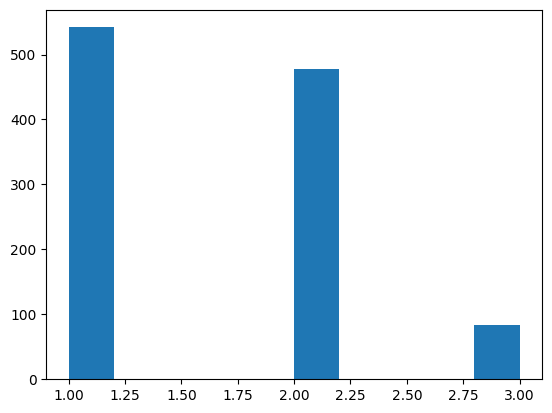

In [60]:
import matplotlib.pyplot as plt


#create histogram from list of data
plt.hist(download_counts)